In [1]:
import glidetools.algorithm.dsd as dsd
import pandas as pd
import numpy as np
import sys
import json
from scipy.spatial.distance import cdist
sys.path.append("../src/")
%load_ext autoreload
%autoreload 2

# Compute DSD matrix of rat and human

In [2]:
ratdf = pd.read_csv("../data/intact_output/rat.s.tsv", sep = "\t", header = None)
humandf = pd.read_csv("../data/intact_output/human.s.tsv", sep = "\t", header = None)
humandf

,0,1
0,Q13643,Q14192
1,P42566,P42566
2,P42566,P42566
3,P33993,Q14192
4,P10275,Q14192
...,...,...
477327,P38398,P38398
477328,P38398,Q96RL1
477329,Q96SB3,P38398
477330,Q13015,Q7L0X0


In [5]:
from io_utils import compute_adjacency, compute_pairs
Ah, humanmap = compute_adjacency(humandf)
Ar, ratmap = compute_adjacency(ratdf)
drh = pd.read_csv("../data/intact_output/human-rat.tsv", sep = "\t")
Erh = compute_pairs(drh, ratmap, humanmap, "rat", "human")

# (df, nmapA, nmapB, orgA, orgB)
# import json
# with open("yeast.json", "w") as yj, open("rat.json", "w") as rj:
#     json.dump(yeastmap, yj)
#     json.dump(ratmap, rj)

         rat  human     score
0       7415  20474  0.027355
1       5019  20474  0.017599
2       6889  20474  0.022956
3       4040  30248  0.045050
4       9620  30473  0.008254
...      ...    ...       ...
46546   2588   5645  0.143185
46547   4817   5645  0.053850
46548  10241   2874  0.017623
46549   5970   2874  0.011263
46550   7607   7469  0.006246

[46551 rows x 3 columns]


In [9]:
import networkx as nx

Gh = nx.from_pandas_edgelist(humandf, 0, 1)
cc = max(nx.connected_components(Gh), key = len)

AttributeError: 'Graph' object has no attribute 'degrees'

,0,1
24214,EBI-16224787,1
26638,Q9UQ49,2
11222,A0A380PE32,2
11995,Q9BQL6,9
13059,P08637,6
...,...,...
32338,P62136-1,47
32387,O15178,112
32388,Q05925,71
32391,Q99581,197


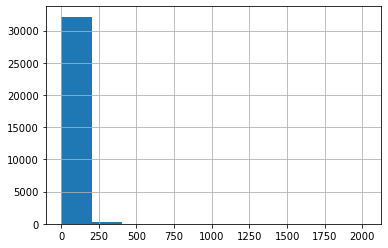

In [23]:
degrees = pd.DataFrame(list(nx.degree(Gh)))
degrees[1].hist()
degrees = pd.concat([degrees.loc[degrees[1] <= 30, :].sample(10000),
                     degrees.loc[degrees[1] > 30, :]])
degrees                     

In [27]:
Ghsub = Gh.subgraph(degrees[0].values)
print(Ghsub.number_of_edges())
Ghcc = max(nx.connected_components(Ghsub), key = len)
Ghccsub = Ghsub.subgraph(Ghcc)
len(Ghcc)

199110


14588

In [30]:
nx.to_pandas_edgelist(Ghccsub).to_csv("../data/intact_output/human_sub.s.tsv", sep = "\t", header = None, index = None)

In [19]:
rratmap = {val: key for key, val in ratmap.items()}
ryeastmap = {val: key for key, val in yeastmap.items()}

In [16]:
def compute_isorank(A1, A2, E, alpha, maxiter = 20, get_R0 = False, get_R1 = False):
    """
    Compute the isorank using the eigendecomposition
    """

    d1 = np.sum(A1, axis = 1).reshape(-1, 1)
    d2 = np.sum(A2, axis = 1).reshape(-1, 1)
    
    P1 = A1 / d1.T
    P2 = A2 / d2.T
    
    E = E / np.sum(E)
    
    d = d1 @ d2.T 
    d = d / (np.sum(d1) * np.sum(d2))
    
    R = (1-alpha) * d + alpha * E
    
    if maxiter <= 0:
        return R
    
    if get_R0:
        R0 = R.copy()
    
    # Reshape R and E
    R = R.T
    E = E.T
    
    for i in range(maxiter):
        R = (1-alpha) * (P2 @ R @ P1.T) + alpha * E
        if get_R1 and i == 0:
            R1 = R.T.copy()
            
    payload = [R.T]
    if get_R1:
        payload = [R1] + payload
    if get_R0:
        payload = [R0] + payload
    return payload

def compute_greedy_assignment(R1, n_align):
    """
    Compute greedy assignment
    """
    aligned = []
    R = R1.copy()
    
    n_align = min(n_align, *R.shape)
    
    itr = 1
    while(len(aligned) < n_align):
        itr   += 1
        maxcols = np.argmax(R, axis = 1) # best y ids
        maxid = np.argmax(np.max(R, axis = 1)) # best x id
        maxcol = maxcols[maxid]
        aligned.append((maxid, maxcol))
        R[:, maxcol] = -1
        R[maxid, :]  = -1
    return aligned


R0 = compute_isorank(Ar, Ay, Erb, 0.6, -1, get_R0 = False, get_R1 = False)
pairs = compute_greedy_assignment(R0, 1000)

In [22]:
diso_rat_yeast = pd.DataFrame(pairs, columns = ["rat", "bakers"])
diso_rat_yeast.iloc[:, 0] = diso_rat_yeast.iloc[:, 0].apply(lambda x : rratmap[x])
diso_rat_yeast.iloc[:, 1] = diso_rat_yeast.iloc[:, 1].apply(lambda x : ryeastmap[x])
diso_rat_yeast.to_csv("isorank_rat_bakers.tsv", sep = "\t", index = None)

# Load JSON from file

In [68]:
list(yeastmap.items())[:10]

[('P38207', 0),
 ('Q01919', 1),
 ('P42840', 2),
 ('P36069', 3),
 ('P35187', 4),
 ('P53273', 5),
 ('Q07410', 6),
 ('P36009', 7),
 ('P11076', 8),
 ('P22135', 9)]

In [10]:
with open("yeast.json", "r") as yj, open("rat.json", "r") as rj:
    yeastmap = json.load(yj)
    ratmap = json.load(rj)
list(yeastmap.items())[:10]

[('P38207', 0),
 ('Q01919', 1),
 ('P42840', 2),
 ('P36069', 3),
 ('P35187', 4),
 ('P53273', 5),
 ('Q07410', 6),
 ('P36009', 7),
 ('P11076', 8),
 ('P22135', 9)]

# Compute DSD matrix

In [34]:
ADyeast = dsd.compute_dsd_embedding(Ay, is_normalized=False)

In [35]:
# np.save("yeast-dsd-emb.npy", ADyeast)
ADrat = dsd.compute_dsd_embedding(Ar, is_normalized = False)

In [36]:
# np.save("rat-dsd-emb.npy", ADrat)

# Load the DSD matrix

In [3]:
ADrat = np.load("rat-dsd-emb.npy")
ADyeast = np.load("yeast-dsd-emb.npy")

In [4]:
from scipy.spatial.distance import pdist, squareform

Drat = squareform(pdist(ADrat))
Dyeast = squareform(pdist(ADyeast))

In [4]:
# np.save("rat-dsd-dist.npy", Drat)
# np.save("yeast-dsd-dist.npy", Dyeast)
Drat = np.load("rat-dsd-dist.npy")
Dyeast = np.load("yeast-dsd-dist.npy")

# Load the GO files for the Yeast network

In [5]:
ynet = pd.read_csv("../data/go/bakers.output.mapping.gaf", sep = "\t")
ynet

,GO,type,sgd,swissprot
0,GO:0000006,molecular_function,S000003224,P32804
1,GO:0000006,molecular_function,S000003224,P32804
2,GO:0000007,molecular_function,S000004120,Q12436
3,GO:0000007,molecular_function,S000004120,Q12436
4,GO:0000009,molecular_function,S000000208,P38211
...,...,...,...,...
61177,GO:1990468,cellular_component,S000004447,Q06188
61178,GO:1990468,cellular_component,S000006235,Q12311
61179,GO:1990537,cellular_component,S000003345,P53267
61180,GO:1990860,cellular_component,S000005952,P17157


In [6]:
rnet = pd.read_csv("../data/go/rat.output.mapping.gaf", sep = "\t")
rnet

,GO,type,rgd,swissprot
0,GO:0000009,molecular_function,1309526,Q5KR61
1,GO:0000010,molecular_function,1359372,Q5U2R1
2,GO:0000010,molecular_function,1359372,Q5U2R1
3,GO:0000014,molecular_function,1308872,B1WC58
4,GO:0000014,molecular_function,1565882,Q5I0M0
...,...,...,...,...
133498,GO:1990780,cellular_component,632281,O35274
133499,GO:1990812,cellular_component,2122,P46933
133500,GO:1990812,cellular_component,2139,P08592
133501,GO:1990812,cellular_component,2623,Q80WE1


In [7]:
rnet.iloc[:, [0, 3]].groupby("swissprot", as_index = False).aggregate(list).values

array([['A0A096MJN4',
        list(['GO:0000287', 'GO:0003924', 'GO:0005525', 'GO:0005525', 'GO:0005525', 'GO:0005525', 'GO:0030382', 'GO:0031398', 'GO:0043065', 'GO:2000647', 'GO:2001244', 'GO:0005739', 'GO:0005856', 'GO:0030424', 'GO:0030425', 'GO:0031514', 'GO:0036126'])],
       ['A0A096MJY4',
        list(['GO:0000976', 'GO:0000976', 'GO:0000977', 'GO:0000977', 'GO:0000977', 'GO:0000977', 'GO:0000977', 'GO:0000977', 'GO:0000978', 'GO:0000987', 'GO:0003680', 'GO:0003680', 'GO:0043565', 'GO:0061629', 'GO:0061629', 'GO:1990837', 'GO:0000122', 'GO:0000122', 'GO:0000122', 'GO:0000122', 'GO:0001947', 'GO:0001947', 'GO:0002634', 'GO:0002634', 'GO:0003138', 'GO:0003138', 'GO:0003139', 'GO:0003139', 'GO:0006351', 'GO:0006351', 'GO:0006355', 'GO:0006355', 'GO:0006357', 'GO:0007519', 'GO:0010613', 'GO:0010628', 'GO:0010628', 'GO:0010628', 'GO:0010629', 'GO:0010629', 'GO:0010694', 'GO:0010694', 'GO:0014033', 'GO:0014033', 'GO:0014902', 'GO:0014902', 'GO:0030224', 'GO:0030279', 'GO:0030279', '

In [33]:
def topk_acc(golists = {}, go = None, k = 1):
    if len(golists) == 0:
        return None
    elif go == None:
        return 0
    else:
        go_k = set(go[: min(k, len(go))])
        return len(go_k.intersection(golists)) / k
    
def topk_accs(prots, pred_go_map, true_go_map, k = 1):
    accs = [topk_acc(true_go_map[p], pred_go_map[p], k) for p in prots]
    accs = list(filter(lambda x : x is not None, accs))
    return np.average(accs)

def compute_metric(prediction_func, scoring_func, allprots, true_go_map, kfold = 5):
    np.random.seed(137)
    permprots = np.random.permutation(allprots)
    blocksize = int(len(allprots) / kfold)
    scores = []
    for i in range(kfold):
        predictprots = permprots[i * blocksize: (i+1) * blocksize]
        trainprots = np.concatenate([permprots[: i * blocksize], permprots[(i+1) * blocksize : ]])
        go_map_training = {tprots: true_go_map[tprots] for tprots in trainprots}
        go_map_training.update({pprots : -1 for pprots in predictprots})
        pred_map = prediction_func(go_map_training)
        scores.append(scoring_func(predictprots, pred_map, true_go_map))
    return scores, np.average(scores)

def predict_dsd(D_mat, train_go_maps, k = 10):
    predprot = [x for x in train_go_maps if train_go_maps[x] == -1]
    D_mat1 = D_mat.copy()
    D_mat1[range(len(D_mat)), range(len(D_mat))] = np.inf
    D_mat1[:, predprot] = np.inf
    sortedD = np.argsort(D_mat1, axis = 1)[:, 1:k+1]
    def vote(neighbors, go_maps):
        gos = {}
        for n in neighbors:
            for g in go_maps[n]:
                if g not in gos:
                    gos[g] = 0
                gos[g] += 1 
        return sorted(gos, key = lambda x : gos[x], reverse=True)
    for p in predprot:
        train_go_maps[p] = vote(sortedD[p], train_go_maps)
    return train_go_maps

def predict_dsd_mundo(D_mat, D_other_species, train_go_maps, go_other, k = 10, k_other = 20):
    predprot = [x for x in train_go_maps if train_go_maps[x] == -1]
    D_mat1 = D_mat.copy()
    D_other = D_other_species.copy()
    D_mat1[range(len(D_mat)), range(len(D_mat))] = np.inf
    D_mat1[:, predprot] = np.inf
    sortedD = np.argsort(D_mat1, axis = 1)[:, 1: k+1]
    sortedDoth = np.argsort(D_other, axis = 1)[:, 1: k_other+1]
    def vote(neighbors, oth_neighbors,  go_maps, vote_other = 0.4):
        gos = {}
        for n in neighbors:
            for g in go_maps[n]:
                if g not in gos:
                    gos[g] = 0
                gos[g] += 1 
        for n in oth_neighbors:
            for g in go_other[n]:
                if g not in gos:
                    gos[g] = 0
                gos[g] += vote_other  
        return sorted(gos, key = lambda x : gos[x], reverse=True)
    for p in predprot:
        train_go_maps[p] = vote(sortedD[p], sortedDoth[p], train_go_maps)
    return train_go_maps

def dsd_func(D_mat, k = 10):
    def pred(train_go_maps):
        return predict_dsd(D_mat, train_go_maps, k = k)
    return pred

def dsd_func_mundo(D_mat, D_other, go_other, k = 10, k_other = 20):
    def pred(train_go_maps):
        return predict_dsd_mundo(D_mat, D_other, train_go_maps, go_other, k, k_other)
    return pred
    
def get_go_maps(nmap, gofile):
    df = pd.read_csv(gofile, sep = "\t")
    gomaps = df.iloc[:, [0, 3]].groupby("swissprot", as_index = False).aggregate(list).values
    go_outs = {}
    for prot, gos in gomaps:
        if prot in nmap:
            go_outs[nmap[prot]] = set(gos)
    return go_outs

In [35]:
yeastgomap = get_go_maps(yeastmap, "../data/go/bakers.output.mapping.gaf")
ratgomap = get_go_maps(ratmap, "../data/go/rat.output.mapping.gaf")
for i in range(len(yeastmap)):
    if i not in yeastgomap:
        yeastgomap[i] = {}
for i in range(len(ratmap)):
    if i not in ratgomap:
        ratgomap[i] = {}
len(yeastgomap), len(ratgomap)

(6478, 10792)

In [31]:
Drat[range(len(Drat)), range(len(Drat))] = np.inf
Dyeast[range(len(Dyeast)), range(len(Dyeast))] = np.inf

# Function Prediction: Without MUNDO output

In [13]:
compute_metric(dsd_func(Drat, k=10), topk_accs, list(range(len(ratmap))), ratgomap, kfold = 5)

([0.05504587155963303,
  0.04788732394366197,
  0.04105571847507331,
  0.03856749311294766,
  0.024242424242424242],
 0.04135976626674804)

In [118]:
compute_metric(dsd_func(Dyeast, k=10), topk_accs, list(range(len(yeastmap))), yeastgomap, kfold = 5)

([0.4046692607003891,
  0.3892100192678227,
  0.3346228239845261,
  0.4182547642928786,
  0.34408602150537637],
 0.3781685779501986)

# Self Attention Model 

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
from sklearn.manifold import Isomap

Drat = np.load("rat-dsd-dist.npy")
Dyeast = np.load("yeast-dsd-dist.npy")
embedding = Isomap(n_components=100, metric = "precomputed")
Yeastemb = embedding.fit_transform(Dyeast)

In [5]:
# np.save("yeast-isomap.npy", Yeastemb)
Yeastemb.shape, embedding.reconstruction_error()

((6478, 100), 0.47086101173166933)

In [18]:
Drat1 = np.where(Drat > 10, 10, Drat)
ratemb = Isomap(n_components=100, metric = "precomputed")
Ratemb = ratemb.fit_transform(Drat1)

In [19]:
ratemb.reconstruction_error()
np.save("rat-isomap.npy", Ratemb)

In [20]:
ratemb.reconstruction_error()

154.40492926819678

In [21]:
class MHA(nn.Module):
    def __init__(self, n_channel, n_head, n_dim, n_out, activation = "identity"):
        super(MHA, self).__init__()
        activations = {"relu" : nn.ReLU(), "sigmoid" : nn.Sigmoid(), "tanh": nn.Tanh()}
        self.Wq = nn.Parameter(torch.randn(n_head, n_dim, n_channel, dtype = torch.float32))
        self.Wk = nn.Parameter(torch.randn(n_head, n_dim, n_channel, dtype = torch.float32))
        self.Wv = nn.Parameter(torch.randn(n_head, n_dim, n_channel, dtype = torch.float32))
        self.drop = nn.Dropout(p=0.2)
        self.activation = activations[activation] if activation in activations else nn.Identity()
        self.n_channel  = nn.Parameter(torch.tensor(n_channel, dtype = torch.float32), requires_grad = False)
        self.Wo = nn.Parameter(torch.randn(n_head * n_channel, n_out))
        
    def forward(self, X):
        # X is batch x n_seq = 100 x n_dim = 1
        X1 = X.unsqueeze(1)
        q  = torch.matmul(X1, self.Wq) # batch x n_head x n_seq x n_channel
        k  = torch.matmul(X1, self.Wk)
        v  = torch.matmul(X1, self.Wv)
        
        att = F.softmax(torch.matmul(q, torch.transpose(k, 2, 3)) / torch.sqrt(self.n_channel), dim = -1) 
        v = torch.matmul(att, v) # batch x n_head x n_seq x n_channel
        v = self.drop(v)
        vc = torch.concatenate(torch.unbind(v, 1), axis = -1)
        return self.activation(torch.matmul(vc, self.Wo))
        
        
class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.mha1 = MHA(10, 4, 1, 4, activation = "sigmoid")
        self.layer = nn.LayerNorm(4)
        self.mha2 = MHA(5, 3, 4, 1)
    def forward(self, x):
        out = self.mha1(x)
        out = self.layer(out)
        return self.mha2(out)

class Data(Dataset):
    def __init__(self, matchfile, no_matches, Xa, Xb, nA, nB):
        self.no_matches = no_matches
        self.matchdf = pd.read_csv(matchfile, sep = "\t")
        
        if "scores" in self.matchdf.columns:
            self.matchdf = self.matchdf.sort_values(by = "score", ascending = False).reset_index(drop = True)[: no_matches]
        else:
            self.matchdf = self.matchdf.loc[: no_matches, :]
            # for compatibility
            self.matchdf["scores"] = 1
        self.nA = nA
        self.nB = nB
        self.Xa = Xa
        self.Xb = Xb
        
    def __len__(self):
        return self.no_matches
    
    def __getitem__(self, idx):
        pa, pb, _= self.matchdf.iloc[idx, :].values
        ia, ib = self.nA[pa], self.nB[pb]
        return torch.tensor(self.Xa[ia], dtype = torch.float32).unsqueeze(-1), torch.tensor(self.Xb[ib], dtype = torch.float32).unsqueeze(-1)
        

In [22]:
#Ratemb = np.load("rat-isomap.npy")
#Yeastemb = np.load("yeast-isomap.npy")
data = Data("isorank_rat_bakers.tsv", 500, Ratemb, Yeastemb, ratmap, yeastmap)

In [23]:
train, test = torch.utils.data.random_split(data, [450, 50])
trainloader = DataLoader(train, shuffle = True, batch_size = 10)
testloader = DataLoader(test, shuffle = True, batch_size = 10)

In [24]:
loss_fn = nn.MSELoss()
loss_fn(data[0][0],data[0][1])

tensor(2.3539)

In [25]:
model = AttentionModel()
model.train()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

ep = 100
losses = []
for e in range(ep):
    loss = 0
    for i, data in enumerate(trainloader):
        y, x = data # y = rat, x = yeast
        optim.zero_grad()
        yhat = model(x)
        closs = loss_fn(y, yhat)
        closs.backward()
        optim.step()
        loss += closs.item()
    loss = loss / (i+1)
    if e % 10 == 0:
        print(f"Epoch {e+1}: Loss : {loss}")

Epoch 1: Loss : 9.55410001542833
Epoch 11: Loss : 6.889253854751587
Epoch 21: Loss : 6.841670523749458
Epoch 31: Loss : 6.81361510488722
Epoch 41: Loss : 6.817086903254191
Epoch 51: Loss : 6.809339904785157
Epoch 61: Loss : 6.809415372212728
Epoch 71: Loss : 6.804392910003662
Epoch 81: Loss : 6.802529101901584
Epoch 91: Loss : 6.803723340564304


In [26]:
testloss = 0
model.eval()
for i, data in enumerate(testloader):
    y, x = data # y = rat, x = yeast
    yhat = model(x)
    loss = loss_fn(y, yhat)
    testloss += loss.item()
testloss /= (i+1)
print(f"Validation loss: {testloss}")

Validation loss: 6.995772361755371


In [27]:
allYeastEmb = torch.tensor(Yeastemb, dtype = torch.float32).unsqueeze(-1)
with torch.no_grad():
    Yeast_RatT = model(allYeastEmb)


In [28]:
yeast_rat = Yeast_RatT.squeeze().numpy()
# np.save("yeast->rat_emb.npy", yeast_rat)

In [29]:
yeast_rat.shape

(6478, 100)

In [30]:
rat_yeast_dist = cdist(Ratemb, yeast_rat) # If rat => m yeast has size n  => m x n

## $\color{red}{\text{With MUNDO output (MASSIVE IMPROVEMENT)!}}$

In [37]:
compute_metric(dsd_func_mundo(Drat, rat_yeast_dist, yeastgomap, k_other=5),
               topk_accs, list(range(len(ratmap))), ratgomap, kfold = 5)

([0.15,
  0.13527851458885942,
  0.134375,
  0.10662824207492795,
  0.15755627009646303],
 0.13676760535205007)

In [36]:
compute_metric(dsd_func_mundo(Drat, rat_yeast_dist, yeastgomap, k_other=20),
               topk_accs, list(range(len(ratmap))), ratgomap, kfold = 5)

([0.2916666666666667,
  0.2917771883289125,
  0.29375,
  0.2910662824207493,
  0.3086816720257235],
 0.2953883618884104)

In [2]:
x = [1,2,3]
y = x + [4,5]
x, y

([1, 2, 3], [1, 2, 3, 4, 5])